In [1]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from glob import glob
import os

import pandas as pd
from scipy import ndimage, spatial
from importlib import reload

import utils

In [207]:
src = '../raw/'
lsrc = src + 'leyre/'
dst = '../proc/'
genes = [ text.split('/')[-1] for text in sorted(glob(lsrc + '*')) ]

In [208]:
gidx = 0
print('Working with gene', genes[gidx])
platefiles = sorted( glob(lsrc + genes[gidx] + '/*.JPG') + glob(lsrc + genes[gidx] + '/*.jpg') )
gdst = dst + lsrc.split('/')[-2] + '/' + genes[gidx] + '/'

Working with gene LBD37


In [237]:
pidx = 5
bname = os.path.split(os.path.splitext(platefiles[pidx])[0])[1]
rgb = utils.load_image(platefiles[pidx], check_rotation=True)

In [238]:
filename = gdst + bname + '_plateslice.csv'
meta = np.loadtxt(filename, delimiter=',', dtype=int)
filename = gdst + bname + '_centers.npy'

plateslice = np.s_[ meta[0]:meta[1], meta[2]:meta[3] ]
diagnostic = rgb[plateslice]

coords = np.load(filename, allow_pickle=True)
nrows = coords.shape[0]
ncols = coords.shape[1]

maximg = np.max(diagnostic, axis=2)
stdimg = np.std(diagnostic, axis=2)
#background = (maximg < meta[4]) & (stdimg < meta[5])
background = (maximg < 180) & (stdimg < 15)

In [239]:
if False:
    fig, ax = plt.subplots(1,1, figsize=(8,5), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel()
    
    ax[0].imshow(diagnostic, vmin=0, origin='upper', cmap='inferno');
    ax[0].axis('off')
    for i in range(nrows):
        ax[0].scatter(coords[i,:,0], coords[i,:,1], color='lime', marker = '.', s=1)
    
    fig.tight_layout();

In [244]:
light_correction = True

#img = diagnostic[:,:,1].copy()
#img = 0.837*diagnostic[:,:,1] + 0.162*diagnostic[:,:,2]
#img = 0.2989*diagnostic[:,:,0] + 0.5870*diagnostic[:,:,1] + 0.1140*diagnostic[:,:,2]
#img = 0.5*diagnostic[:,:,1] + 0.5*diagnostic[:,:,2]
img = np.where(diagnostic[:,:,1] > diagnostic[:,:,2], diagnostic[:,:,1], diagnostic[:,:,2])

if light_correction:
    size = 725
    eimg = ndimage.grey_erosion(diagnostic[:,:,1], size=size, mode='constant', cval=255)
    cimg = ndimage.grey_dilation(eimg, size=size, mode='constant', cval=0)
    unif = ndimage.uniform_filter(cimg, size=size//3, mode='reflect')
    unif[ unif > img ] = img[unif > img]
    corr = img - (unif)
    corr2 = corr.copy()
    corr2[background] = 0
else:
    corr2 = img.copy()
    corr2[background] = 0

#maximg = ndimage.maximum_filter(corr2, size=15, mode='constant', cval=0)
#peaks = ndimage.binary_dilation(~background & (maximg == corr2), ndimage.generate_binary_structure(2,1), iterations=5)
#norm = corr2*(~peaks)
#norm = 255*(norm - norm.min()).astype(float)/norm.max()
#norm = norm.astype(np.uint8)

In [241]:
R = 25
q = np.zeros((nrows, ncols))

for row in range(nrows):
    for col in range(ncols):
        pos = coords[row,col,:].astype(int)
        if np.sum(pos) > 10:
            slic = np.s_[pos[1] - R : pos[1] + R + 1, pos[0] - R : pos[0] + R + 1]
            foo = corr2[slic]
            q[row,col] = np.quantile(foo[foo > 0], 0.5)
        else:
            q[row,col] = 0

filename = gdst + bname + '_colormatrix.csv'
print(filename)
np.savetxt(filename, q, delimiter=',', fmt='%.1f')

../proc/leyre/LBD37/20231130_plate_06_colormatrix.csv


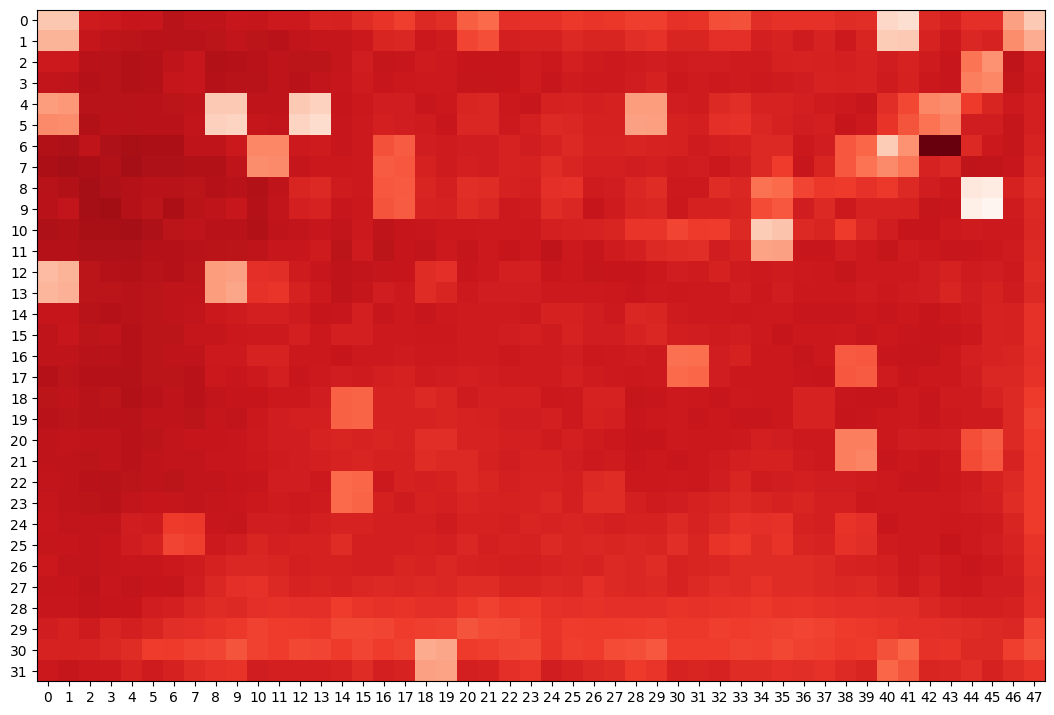

In [242]:
fig, ax = plt.subplots(1,1, figsize=(13,9), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()
ax[0].imshow(q, cmap='Reds_r', vmin=0)
ax[0].set_xticks(range(ncols), range(ncols))
ax[0].set_yticks(range(nrows), range(nrows));

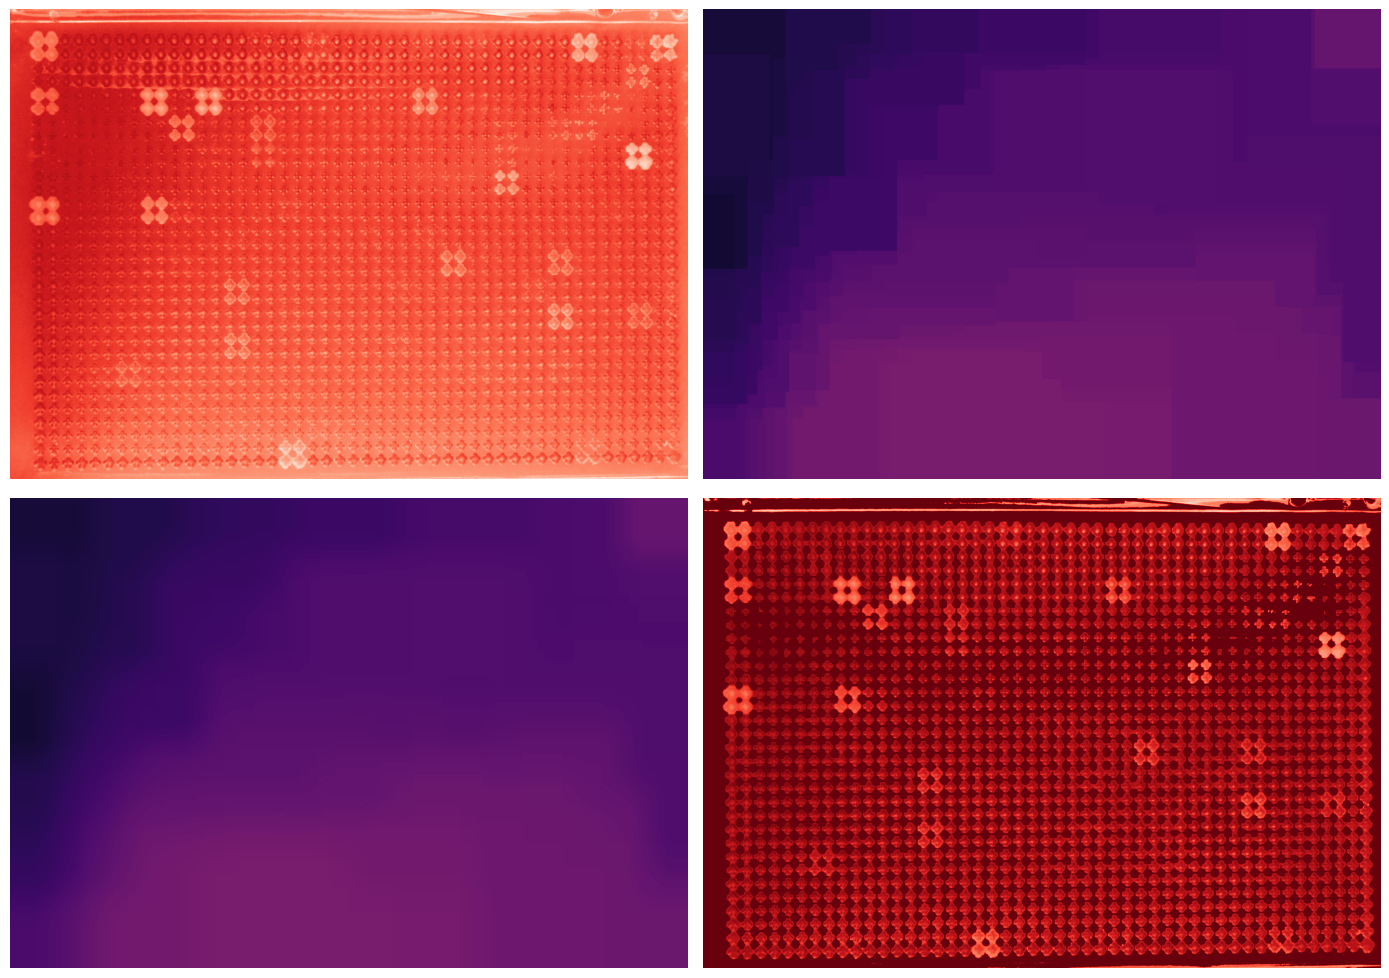

In [245]:
fig, ax = plt.subplots(2,2, figsize=(14,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

vmax = np.max(corr2)

ax[i].imshow(img, vmin=0, origin='upper', cmap='Reds_r'); i+=1
ax[i].imshow(cimg, vmin=0, vmax=255, origin='upper', cmap='inferno'); i+=1
ax[i].imshow(unif, vmin=0, vmax=255, origin='upper', cmap='inferno'); i+=1
ax[i].imshow(corr2, vmin=0, vmax=vmax, origin='upper', cmap='Reds_r'); i+=1

for i in range(len(ax)):
    ax[i].axis('off')
    
fig.tight_layout();

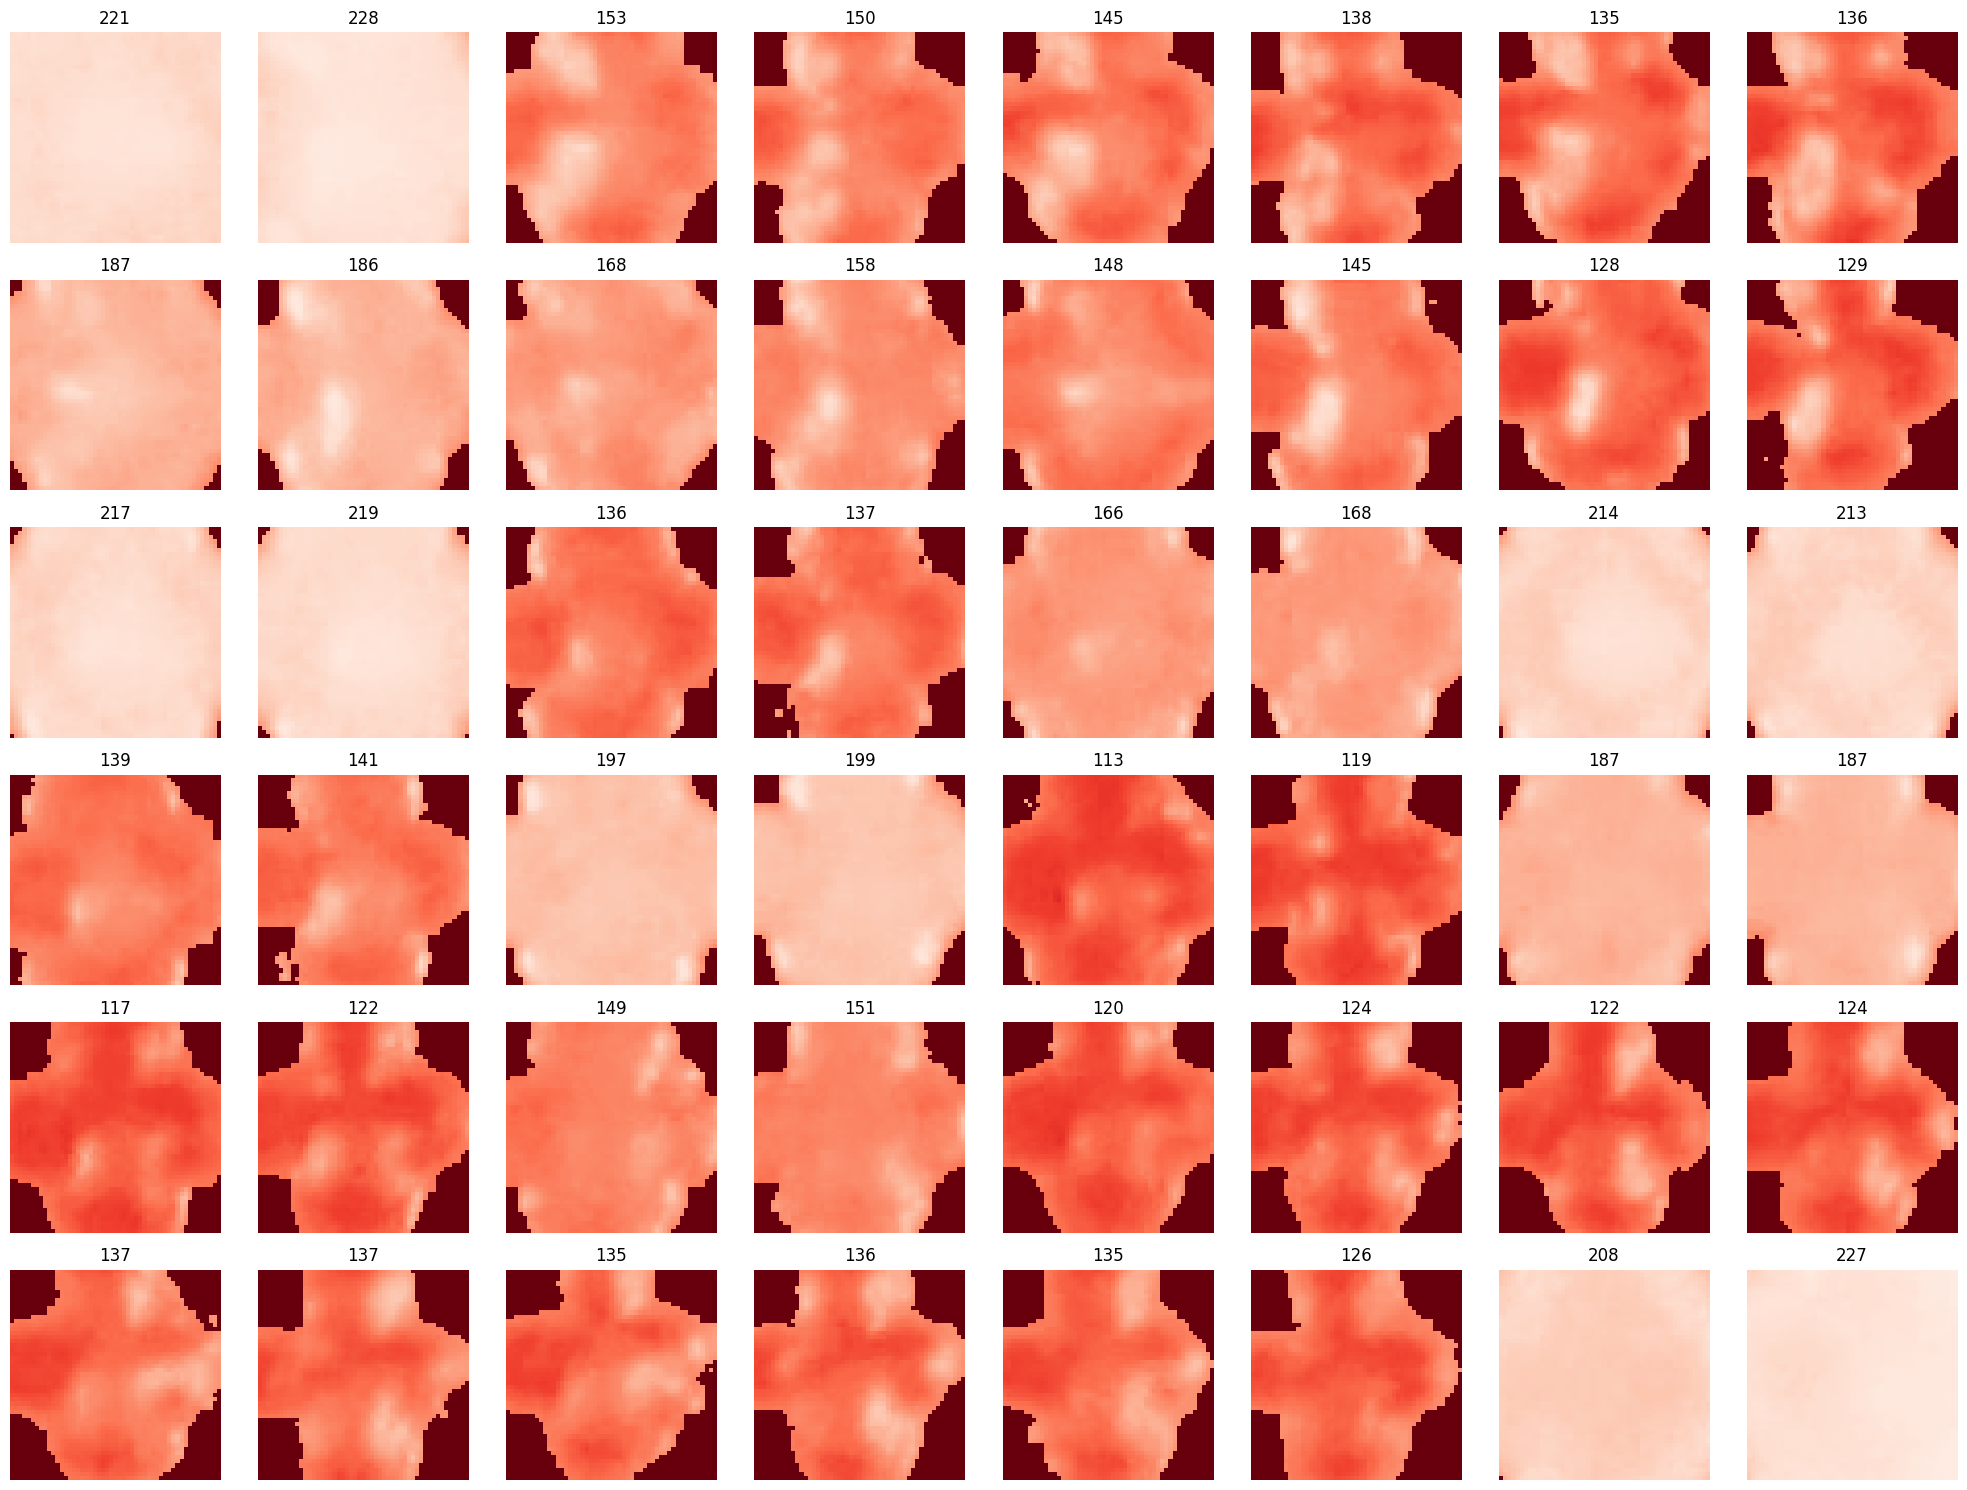

In [109]:
row = 11
fig, ax = plt.subplots(6,8, figsize=(20,15), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    pos = coords[row,i]
    if np.sum(pos) > 10:
        slic = np.s_[pos[1] - R : pos[1] + R + 1, pos[0] - R : pos[0] + R + 1]
        foo = corr2[slic]
        med = np.median(foo[foo > 0])
        ax[i].imshow(foo, origin='upper', cmap='Reds_r', vmax=vmax, vmin=0);
        ax[i].set_title(int(med))
    ax[i].axis('off')

fig.tight_layout();